# Demo: Preprocessing

In this demo you'll learn how to load a Fit file, apply one or more pre-processing transforms (such as converting to numpy) and then how to efficiently save this data to create an ML-ready dataset.

In future tutorials we'll dive into how to do this in an even more efficent way!

In [26]:
import autoroot
from typing import Callable
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.auto as tqdm
import os
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
from sunpy.map import Map
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from helio_tools._src.utils.io import get_list_filenames

base_path = os.getcwd() + "/sdo-data"

ext = ".fits"

data_filenames = get_list_filenames(base_path, ext)
print(len(data_filenames))



40


## Preprocessing

In [28]:
from helio_tools._src.editors.load import load_fits_to_map
from helio_tools._src.editors.scale import normalize_radius, normalize_fn, MapImageNormalize
from helio_tools._src.editors.calibration import correct_degregation
from helio_tools._src.editors.datastructure import map_to_ndarray
from astropy.visualization import AsinhStretch
from einops import rearrange
from toolz import compose_left, partial

### 1. Filter Files for Wavelength

First, we will filter the files for the wavelength `304`. 
We will also only take a demo file for this demonstration.

In [29]:
# filter for wavelength 304
data_filenames_304 = list(filter(lambda k: '304' in k, data_filenames))

# pick the first file for demonstration purposes
demo_file: str = data_filenames_304[0]

### 2. `.fits` file to `Map`

Next, we will load the `.fits` file to a `sunpy.map.Map` object. 
This is a very convenient object to work with because `.fits` files are very unintuitive for the inexperienced. 
So we will use this higher order wrapper instead of dealing directly with `.fits` files.

See the [sunpy.map](https://docs.sunpy.org/en/stable/reference/map.html) docs for more details.

In [30]:
# create function that explicitly loads fits file, and matches it to a Map object

# alternatively you can do out = load_fits_to_map(demo_file)

fn1: Callable[[Map, ...], Map] = load_fits_to_map 

# apply function
out: Map = fn1(demo_file)

We can directly plot the image along with the distribution of pixels and the associated meta-data.

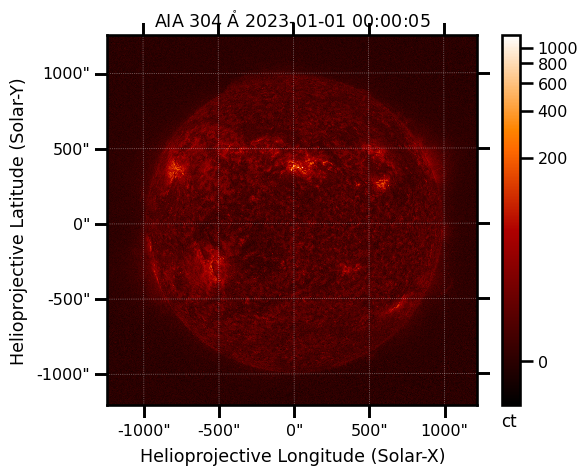

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / data type of original image                    
NAXIS   =                    2 / dimension of original image                    
NAXIS1  =                 4096 / length of original image axis                  
NAXIS2  =                 4096 / length of original image axis                  
BLD_VERS= 'V9R5X   '           / Build Version: from jsoc_version.h             
LVL_NUM =                  1.0 / LVL_NUM data level number                      
T_REC   = '2022-12-31T23:59:59Z' / [ISO] Slotted observation time               
TRECSTEP=                  1.0 / [second] T_REC step {T_REC_step}               
TRECEPOC= '1977.01.01_00:00:00.000_TAI' / [TAI]                                 
TRECROUN=                    1 / center of slot {T_REC_round}                   
ORIGIN  = 'SDO/JSOC-SDP'       / ORIGIN Location where file made                
DATE    = '2023-01-07T15:05:

In [31]:
out.peek()
out.fits_header

### 3. Normalized Radius

Next, we will normalized the radius by some resolution. 
We also have the option to crop the edge bits that we don't want within the image.

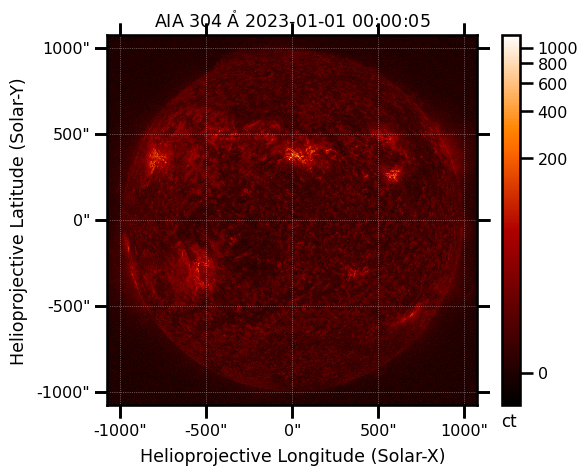

In [32]:
# define parameters
resolution = 2048
crop = True
padding_factor = 0.1

# define function
fn2: Callable[[Map, ...], Map] = partial(normalize_radius, resolution=resolution, padding_factor=padding_factor, crop=crop)

# apply function
out: Map = fn2(out)

# plot output
out.peek()

### 3. Correct Degregation

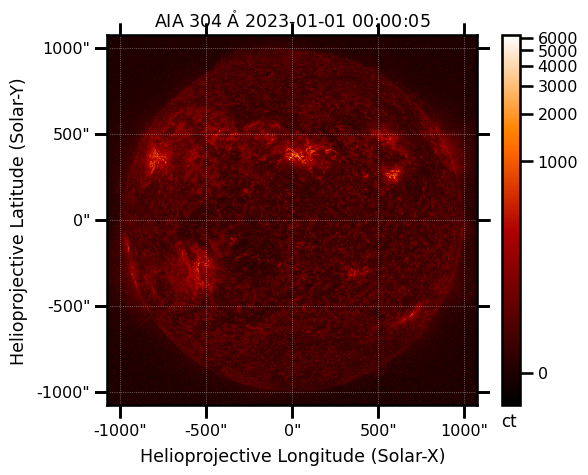

In [33]:
# define parameters
method = "auto"

# define function
fn3: Callable[[Map, ...], Map]  = partial(correct_degregation, method=method)

# apply function
out: Map = fn3(out)

# plot output
out.peek()

### 5. Normalization

We immediately notice that the image is not really clear about the quantities within. 
So we need to do some sort of normalization. 
In this case, we will use some predefined normalization schemes found [here](https://github.com/spaceml-org/MDRAIT_ITI/blob/master/iti/data/editor.py#L60). 
We will define it here manually for more clarity.

In [34]:
# define normalization parameters
a = 0.001
stretch = AsinhStretch(a=a)
vmin, vmax = 0, 8_800
clip = True
fn5: MapImageNormalize = MapImageNormalize(
    stretch=stretch, vmin=vmin, vmax=vmax, clip=clip
)

# define function
# fn5: Callable[[np.ndarray, ...], np.ndarray] = partial(normalize_fn, fn=norm)

# apply function
out: Map = fn5(out)

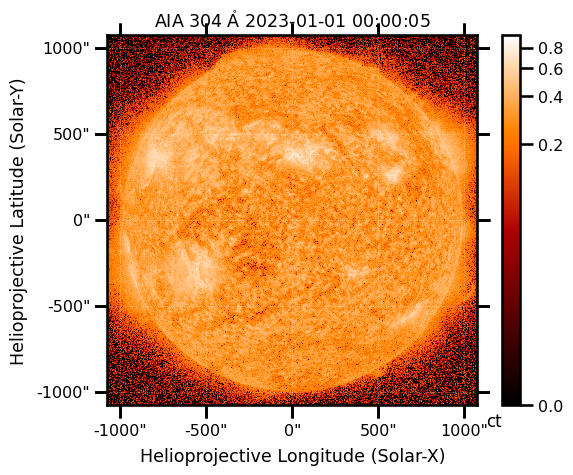

In [35]:
out.peek()

This image is much clearer and we can see some distinct featureswithin the image.

### 6. Channel Dimension

We would like to save our new image to be "ML-Ready". 
However, we need to save it in an image-like format.
We are using the `numpy` convention so we'll save it as: 

`Height x Width x Channel`

In [37]:
# # define parameters

# pattern: str = 'H W -> H W 1'
# H = W = resolution

# # define function
# fn6: Callable[[np.ndarray, ...], np.ndarray]  = lambda x: rearrange(x, pattern=pattern, H=H, W=W)

# # apply function
# out: np.ndarray = fn6(out)

# assert out.shape == (resolution, resolution, 1)

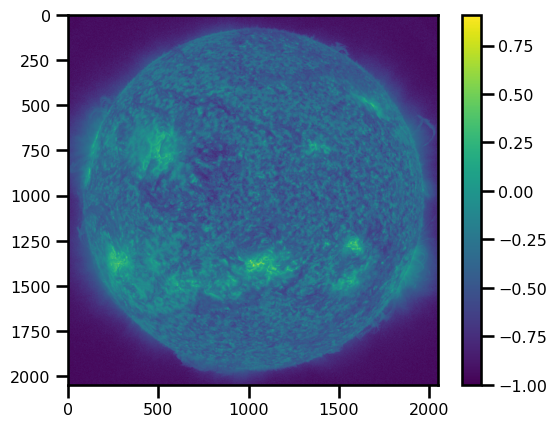

In [ ]:
# plot function
fig, ax = plt.subplots()

pts = ax.imshow(out)
fig.colorbar(pts)

plt.show()

## Stacking Transforms

It's a bit cumbersome to type all of the functions out.
Now, we will stack together some transformations to make a *pipeline*. 

In [38]:
# create composition function
fn: Callable[[str], np.ndarray] = compose_left(fn1, fn2, fn3, fn5)

# pipe demo file through transformations
out_: Map = fn(demo_file)

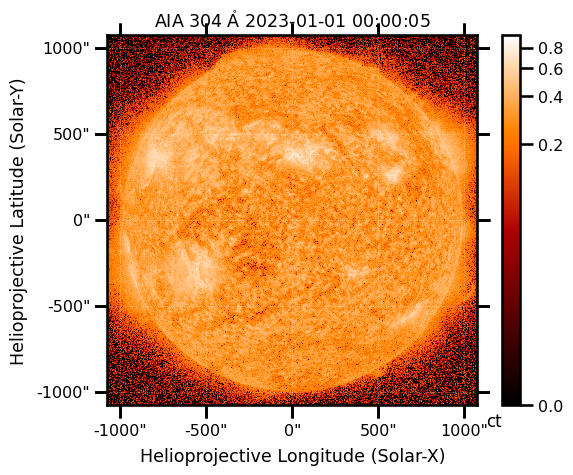

In [39]:
out_.peek()

We can check to make sure that the array is equation.

In [40]:
np.testing.assert_array_almost_equal(out.data, out_.data)

## ML-Ready Data

Now, we want to apply these functions over all of the files within the dataset.
We will save it in two different file formats

#### `numpy.ndarray`

In [41]:
from pathlib import Path

In [42]:
save_base_path = Path(os.getcwd() + "/sdo-data-npy/304")
save_base_path.mkdir(parents=True, exist_ok=True)

In [44]:
pbar = tqdm.tqdm(data_filenames_304[5:10])
for ifile in pbar:
    try: 
        # grab stem save
        ifile_stem = Path(ifile).stem
        pbar.set_description(f"File: {ifile_stem}")

        # transform file
        out = fn(ifile)

        # save name
        save_path = save_base_path.joinpath(ifile_stem + ".npy")

        #
        np.save(save_path, out.data)
    except ValueError:
        pass

  0%|          | 0/3 [00:00<?, ?it/s]

### Parallelization

The above section is an embarassingly parallel operation.
In other words, we can use multiple processes to parallize this operation.
Without doing too much work, we'll use the `joblib` to parallize the operations.

In [45]:
from joblib import Parallel, delayed

First, we'll wrap the entire operation

In [46]:
def parallel_step(ifile):

    try:
        # transform file
        out = fn(ifile)

        # grab stem save
        ifile_stem = Path(ifile).stem

        # save name
        save_path = save_base_path.joinpath(ifile_stem + ".npy")

        # save to `.npy` file
        np.save(save_path, out.data)
    except ValueError:
        pass
    

In [47]:
n_jobs = 4
verbose = 3
results = Parallel(n_jobs=n_jobs, verbose=verbose)(
        delayed(parallel_step)(ifile) for ifile in data_filenames_304[:50]
    )

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   8 | elapsed:    5.8s remaining:    5.8s
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    9.6s finished


In [48]:
parent_path = Path(save_path).parent
!du -h $parent_path

321M	/home/juanjohn/projects/helio_tools/notebooks/sdo-data-npy/304


### Saving Images

In [49]:
save_base_path = Path(os.getcwd() + "/sdo_png/304")
save_base_path.mkdir(parents=True, exist_ok=True)

In [50]:
# from skimage.io import imsave
from imageio import imsave

In [51]:
for ifile in tqdm.tqdm(data_filenames_304[:10]):
    
    # transform file
    out = fn(ifile)

    # grab stem save
    ifile_stem = Path(ifile).stem

    # save name
    save_path = save_base_path.joinpath(ifile_stem + ".png")

    # save to `.npy` file
    imsave(save_path, (255 * out.data).squeeze().astype(np.uint8), )
    

  0%|          | 0/8 [00:00<?, ?it/s]

In [52]:
def parallel_step(ifile):

    # transform file
    out = fn(ifile)

    # grab stem save
    ifile_stem = Path(ifile).stem

    # save name
    save_path = save_base_path.joinpath(ifile_stem + ".png")

    # save to `.npy` file
    imsave(save_path, (255 * out.data).squeeze().astype(np.uint8), )

In [53]:
n_jobs = 4
verbose = 3
results = Parallel(n_jobs=n_jobs, verbose=verbose)(
        delayed(parallel_step)(ifile) for ifile in data_filenames_304[:50]
    )

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   8 | elapsed:    3.8s remaining:    3.8s
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    7.6s finished


In [54]:
parent_path = Path(save_path).parent
!du -h $parent_path

24M	/home/juanjohn/projects/helio_tools/notebooks/sdo_png/304
